## Large Language Model
Large pre-trained language models such as GPT can be useful for many natural language tasks other than text generation. In this project, I am taking a look at one such task: question-answering (QA).

In a typical QA task, the model is given some **context** text and a **question** related to the context. The model is tasked to generate the correct answer based on the context and question. For example, a context could be "Joe enjoys pizza but prefers pasta over anything else", and given a question "What's Joe's favorite food", the model should output "pasta".

Here, I am extending and fine-tuning a pre-trained large language model (GPT2) to perform question-answering task.

In [1]:
# Required libraries
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00


### 1.1 SQuAD Dataset

A popular dataset for question-answering task is the Stanford Question-answering Dataset (SQuAD) ([Rajpurkar, Pranav, et al. "Squad: 100,000+ questions for machine comprehension of text." arXiv preprint arXiv:1606.05250 (2016).](https://arxiv.org/abs/1606.05250)).
```

In [2]:
from datasets import load_dataset
squad_dataset = load_dataset("squad")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [3]:
####################################################################################
# Training split
print("Train split:", squad_dataset['train'].num_rows)
print("Sample id:", squad_dataset['train'][0]['id'])
print("Context:", squad_dataset['train'][0]['context'])
print("Question:", squad_dataset['train'][0]['question'])
print("Answers:", squad_dataset['train'][0]['answers']['text'])
print("Answers Starting Index:", squad_dataset['train'][0]['answers']['answer_start'])
print()
# Validation split
print("Validation split:", squad_dataset['validation'].num_rows)
print("Sample id:", squad_dataset['validation'][0]['id'])
print("Context:", squad_dataset['validation'][0]['context'])
print("Question:", squad_dataset['validation'][0]['question'])
print("Answers:", squad_dataset['validation'][0]['answers']['text'])
print("Answers Starting Index:", squad_dataset['validation'][0]['answers']['answer_start'])
####################################################################################

Train split: 87599
Sample id: 5733be284776f41900661182
Context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answers: ['Saint Bernadette Soubirous']
Answers Starting Index: [515]

Validation split: 10570
Sample id: 56be4db0acb8001400a502ec
Context: Super Bowl 50 was 

### 1.2 Extending GPT2 for question-answering task
In this part, I am extending the GPT2 model to produce answers from the context based on the questions. To make use of the pre-trained GPT2 model, I am treating it as a feature extractor to compute token-wise feature vectors and add additional MLP layers to process the features for the QA task. These additional task-specific layers are sometimes called **"adapters"**.

Unlike image data, text input can have varying length, which makes batch training and loss computation more challenging.
For simplicity, I am assuming that the batch size is 1 in this question. I.e., the `question`, `context` and `answer` belong to a single sample in the dataset.

In [4]:
import torch
import torch.nn as nn
from transformers import GPT2TokenizerFast, GPT2Model

class GPT2QuestionAnswering(nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
        self.gpt2 = GPT2Model.from_pretrained('gpt2')

        # Add additional layers for predicting the location of the answer
        # Start locations
        hidden = self.gpt2.config.hidden_size
        self.start_class1 = nn.Linear(hidden, 1)

        # End locations
        self.end_class1 = nn.Linear(hidden, 1)

    def forward(self, question, context, answer=None):
        inputs = self.tokenizer(question, context, return_tensors='pt', return_offsets_mapping=True)
        input_ids = inputs.input_ids[:,:self.gpt2.config.n_positions]
        attention_mask = inputs.attention_mask[:,:self.gpt2.config.n_positions]
        if torch.cuda.is_available:
            input_ids = input_ids.cuda()
            attention_mask = attention_mask.cuda()
        features = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)['last_hidden_state']

        # Using the additional layers to compute location of the answer based on the hidden state features
        features_start = self.start_class1(features)
        output_start = features_start.squeeze()

        features_end = self.end_class1(features)
        output_end = features_end.squeeze()

        if self.training:
            # In training mode, we want to return the loss based on the ground truth answer
            # You may change the
            return self.loss(answer, output_start, output_end, inputs.offset_mapping[0])
        else:
            # In inference mode, we want to return the answer string based on the predicted start and end indices
            answer_start_index = output_start.argmax().item()
            answer_end_index = output_end.argmax().item()
            return self.tokenizer.decode(inputs.input_ids[0, answer_start_index : answer_end_index + 1]).strip()

    def loss(self, answer, output_start, output_end, offsets_mapping):
        # Compute the loss based on the answers

        answer_idx_start = answer['answer_start'][0]
        answer_idx_end = answer_idx_start + len(answer['text'][0]) - 1

        start_loc = 0
        end_loc = 0
        for index, offset in enumerate(offsets_mapping):
          if offset[0] <= answer_idx_start and offset[1] > answer_idx_start:
            start_loc = index
          if offset[0] <= answer_idx_end and offset[1] > answer_idx_end:
            end_loc = index

        idx_start = torch.zeros(len(output_start))
        idx_start[start_loc] = 1
        idx_start = idx_start.cuda()
        idx_end = torch.zeros(len(output_end))
        idx_end[end_loc] = 1
        idx_end = idx_end.cuda()

        start_loss = nn.CrossEntropyLoss()(output_start, idx_start)
        end_loss = nn.CrossEntropyLoss()(output_end, idx_end)
        total_loss = (start_loss + end_loss) / 2
        return total_loss

We can evaluate the pre-trained model's performance on the validation split. Since the model has not been adapted to the question-answering task yet, and additional untrained layers have been added, we expect the model to perform poorly.

In question-answering task, we use two evaluation metrics:
* **Exact match**: the percentage of predictions that match the ground truth answer exactly
* **F1 score**: the average overlap (in terms of tokens) between the prediction and ground truth answer

Higher values are better for both metrics. For reference, humans can achieve 77.0% exact match and 86.8% F1 score, while SOTA method achieves 90% exact match and over 95% F1 score.

In [5]:
def evaluate(model, dataset, metric):
    from tqdm.autonotebook import tqdm
    model = model.eval()
    preds = []
    for idx, data in enumerate(tqdm(dataset['validation'])):
        preds.append(dict(id=data['id'], prediction_text=model(data['question'], data['context'], data['answers'])))
    references = [dict(answers=data['answers'], id=data['id']) for data in dataset['validation']]
    return metric.compute(predictions=preds, references=references)

In [6]:
from datasets import load_metric
squad_metric = load_metric('squad')
model = GPT2QuestionAnswering()
if torch.cuda.is_available:
    model = model.cuda()

<ipython-input-6-2a486ba8e79c>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  squad_metric = load_metric('squad')


In [7]:
evaluate(model, squad_dataset, squad_metric)

  0%|          | 0/10570 [00:00<?, ?it/s]

{'exact_match': 0.05676442762535478, 'f1': 2.87476764269864}

### 1.3 Fine-tuning GPT2 on Squad
To adapt a pre-trained model to a specific downstream task (in this case the question-answering task), a common technique is to **"fine-tune"** the model. Fine-tuning simply means training the model using task-specific data, typically with shorter epochs and smaller learning rates. Certain part of the model (e.g., pre-trained layers or early layers) can also be frozen, meaning the weights are not updated during training.

In this part, I am fine-tuning the model on SQuAD dataset. I am implementing the training loop and recording the loss values in a list to be plotted later.

In [8]:
from tqdm.autonotebook import tqdm
import random
losses = []

num_epochs = 1
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
rows = squad_dataset['train'].num_rows

model = model.train()
for e in range(num_epochs):
    # Shuffle dataset in each epoch
    indices = list(range(rows))
    random.shuffle(indices)
    # tqdm gives you a nice little progress bar
    pbar = tqdm(indices)
    for i, idx in enumerate(pbar):
        # Obtain data from training split
        data = squad_dataset['train'][idx]
        optimizer.zero_grad()
        loss = model(data['question'].strip(), data['context'].strip(), data['answers'])
        loss.backward()
        optimizer.step()

        # Record loss values
        losses.append(loss.item())
        pbar.set_postfix(loss=loss.item())

  0%|          | 0/87599 [00:00<?, ?it/s]

Plot the loss values over the iterations.

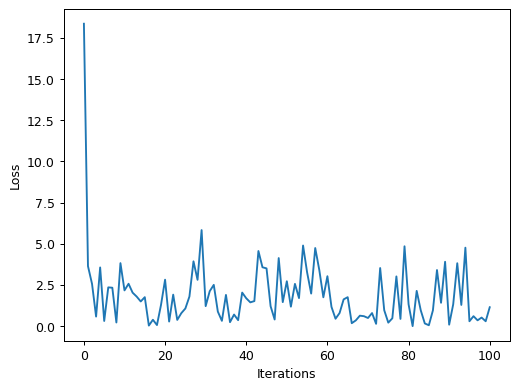

In [17]:
import matplotlib.pyplot as plt

# Reduce the number of points
points = 100
stride = len(losses) // points
plot_losses = losses[::stride]

# Plot the figure
plt.figure(dpi=90)
plt.plot(plot_losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

Evaluate the model performance after fine-tuning. The score should be higher compared to previous results.

In [9]:
evaluate(model, squad_dataset, squad_metric)

  0%|          | 0/10570 [00:00<?, ?it/s]

{'exact_match': 52.223273415326396, 'f1': 63.21990249356342}